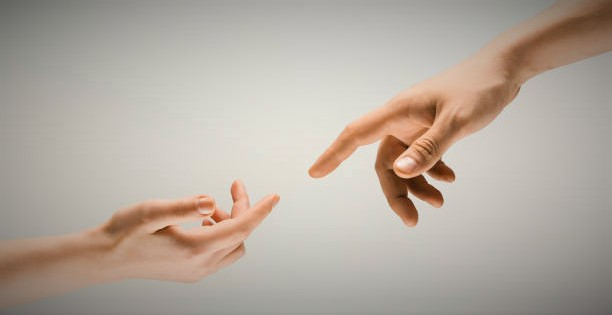

In [387]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,VotingClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import glob
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [347]:
Alone=0
Spontan=1
Sync=2

def LoadData(path):
        AloneList=[];SpontanList=[];SyncList=[]
        all_files = glob.glob(path + "/*")
        for folder in all_files:
            print("\nloading in" ,os.path.basename(folder), ':')
            files = glob.glob(folder + "/*.csv")
            files=last3(files)
            for filename in files:
                df = pd.read_csv(filename, index_col=None, header=0)
                type = None
                
                if("Alone" in filename):
                    type = Alone
                    df=transform(df,type)
                    AloneList.append(df)
                elif("Sync" in filename):
                    type = Sync
                    df=transform(df,type)
                    SyncList.append(df)
                elif("Spontan" in filename):
                    type = Spontan
                    df=transform(df,type)
                    SpontanList.append(df)
                   
                print(os.path.basename(filename), type)
        listData = np.array([AloneList,SpontanList,SyncList])
        return listData


def last3(files):
    lafile=[]
    for i in range(3):
        latest_file = max(files, key=os.path.getmtime)
        lafile.append(latest_file)
        files.remove(latest_file)
    return lafile

def transform(df,type):
    df=df.dropna().reset_index(drop=True)
    df.iloc[:,0] = df.iloc[:,0] - df.iloc[:,0][0]
    df = remove7(df)
    df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]
#     df.iloc[:,0]=df.iloc[:,0].round()
    df.iloc[:,0] = df.iloc[:,0].astype(int)
    if type==0:
        df = df[df.iloc[:,3] == 1]
        return df
    df = df[df.iloc[:,3] != 1]
    df = df.drop(columns=df.columns[3])
    df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
    df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
    df_right = df_right.drop(columns=df_right.columns[2])
    df_left = df_left.drop(columns=df_left.columns[2])
    df=pd.merge(df_right, df_left, left_index=True, right_index=True)
    df.columns=[c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
    return df

    
def remove7(df):
    return df[df.iloc[:,0]>7].reset_index(drop=True)

In [348]:
pathTrain=r'C:\Users\נעמיה\data-science\extraFiles\Training'
pathTest=r'C:\Users\נעמיה\data-science\extraFiles\Validation'
print('Load the train data:')
listTrain=LoadData(pathTrain)
print('\nLoad the test data:')
listTest=LoadData(pathTest)

Load the train data:

loading in Evyatar Cohen :
Evyatar636771054555711409Alone.csv 0
Evyatar636771053639929594Sync.csv 2
Evyatar636771052727603804Spontan.csv 1

loading in Nofar Social_Nuero :
Nofar636759797397919664Sync.csv 2
Nofar636759796290435160Alone.csv 0
Nofar636759795182793299Spontan.csv 1

loading in Oriya Social_Nuero :
Oriya636759806131350399Sync.csv 2
Oriya636759805268396661Alone.csv 0
Oriya636759804404113837Spontan.csv 1

loading in Orya Kalmanovitz :
OryaB636771084494502229Sync.csv 2
OryaB636771083605535985Spontan.csv 1
OryaB636771082736601528Alone.csv 0

loading in Revital Marbel :
Revital636770957894370062Sync.csv 2
Revital636770957038873193Spontan.csv 1
Revital636770955999435879Alone.csv 0

loading in Shahar Terner :
Sachar636771047408504303Alone.csv 0
Sachar636771046527112972Sync.csv 2
Sachar636771045591258071Spontan.csv 1

loading in Shelly Social_Nuero :
Shelly636759789526313406Sync.csv 2
Shelly636759788383205274Alone.csv 0
Shelly636759787508979097Spontan.csv 1

lo

In [349]:
print(listTrain.shape)
print(listTest.shape)

(3, 9)
(3, 3)


In [350]:
AloneRight = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\HandRight.csv')
AloneRight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [351]:
#drop rows with NaN value
AloneRight = AloneRight.dropna()

#change columns name
AloneRight = transform(AloneRight,0)

#replace 'left' at 'right'
for index, row in AloneRight.iterrows():
    AloneRight.loc[index,'HandType']='right'
    
#if there are duplicate rows - delete them
AloneRight=AloneRight.drop_duplicates().reset_index(drop=True)

In [352]:
def mergeAlone(listdata):
    for i in range(len(listdata)):
        temp=AloneRight
        if len(listdata[i])>len(AloneRight):
            temp=pd.concat([AloneRight,AloneRight]).reset_index(drop=True)
        spare = len(temp)-len(listdata[i])
        temp = temp.drop(temp.tail(spare).index)
        temp = temp.drop(columns=temp.columns[[2,3]])
        listdata[i] = listdata[i].drop(columns=listdata[i].columns[[2,3]])
        df=pd.merge(temp, listdata[i], left_index=True, right_index=True)
        df.columns = [c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
        listdata[i] = df.reset_index(drop=True)
    return listdata

In [353]:
listTrain[Alone]=mergeAlone(listTrain[Alone])
listTest[Alone]=mergeAlone(listTest[Alone])

In [354]:
listTrain[0][1]['TimeLeft']

0        7
1        7
2        7
3        7
4        7
        ..
3955    73
3956    73
3957    73
3958    73
3959    73
Name: TimeLeft, Length: 3960, dtype: int32

In [355]:
aa1=listTrain[0][1].query('30<=TimeRight<=32').iloc[::2,]
aa2=listTrain[1][1].query('30<=TimeRight<=32').iloc[::2,]
aa3=listTrain[2][1].query('30<=TimeRight<=32').iloc[::2,]

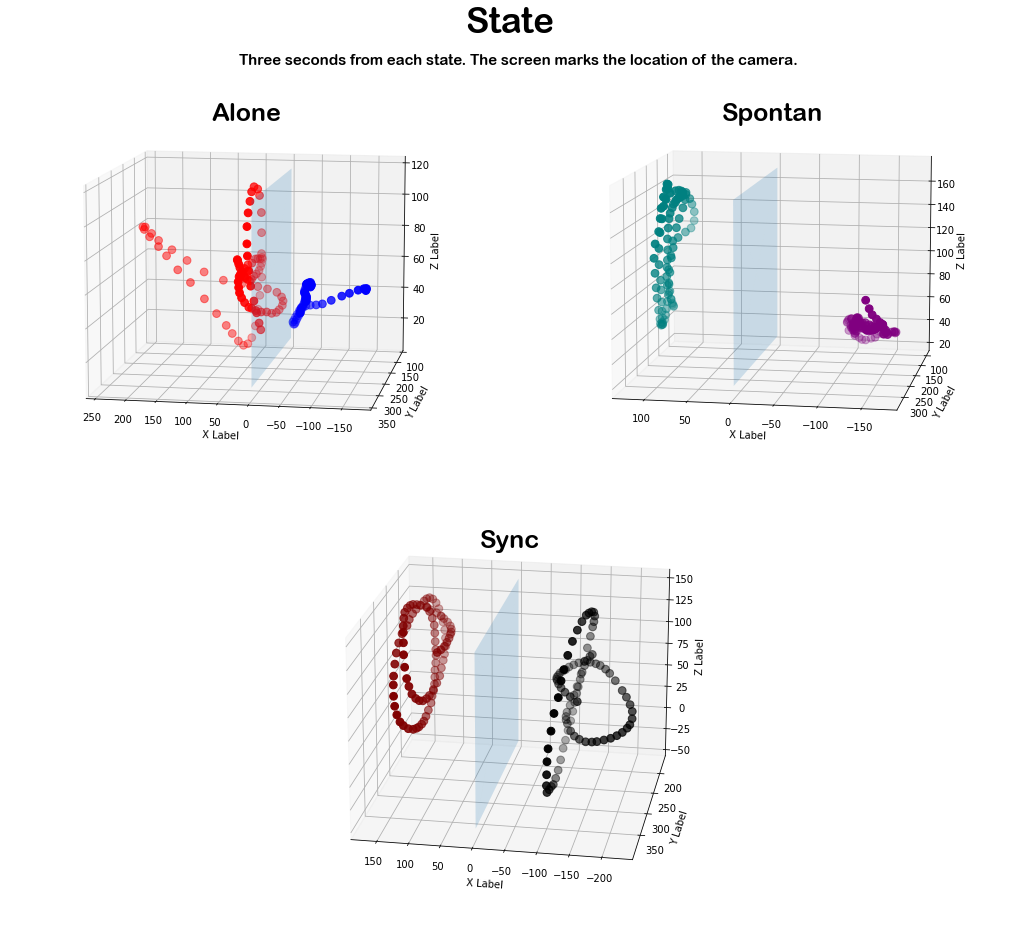

In [356]:
def Max(sr1,sr2):
    return max(max(sr1),max(sr2))
def Min(sr1,sr2):
    return min(min(sr1),min(sr2))

def scatterplot(df,c1,c2,title,elev,azim):
    ax.scatter(df['PositionXRight'], df['PositionYRight'], df['PositionZRight'], c=c1, marker='o',s=60)
    ax.scatter(df['PositionXLeft'], df['PositionYLeft'], df['PositionZLeft'], c=c2, marker='o',s=60)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ymin=Min(df['PositionYLeft'],df['PositionYRight'])
    zmin=Min(df['PositionZLeft'],df['PositionZRight'])
    ymax=Max(df['PositionYLeft'],df['PositionYRight'])
    zmax=Max(df['PositionZLeft'],df['PositionZRight'])
    x = [0, 0, 0, 0]
    y = [ymin, ymin, ymax, ymax]
    z = [zmin, zmax, zmin, zmax]
    vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
    tupleList = list(zip(x, y, z))
    poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
    collection = Poly3DCollection(poly3d, linewidths=1, alpha=0.1)
    ax.add_collection3d(collection)
    ax.set_title(title,fontsize = 25, fontweight='light',fontfamily=font, y=0.93)
    ax.view_init(elev,azim)
font='Arial Rounded MT Bold'
fig = plt.figure(3,figsize=(18,25),)
plt.text(x=0.231,y=1,s='Three seconds from each state. The screen marks the location of the camera.',fontfamily=font,fontsize = 15)
plt.title('State',fontsize = 35, fontweight='bold',fontfamily=font, y=1.03)
plt.axis('off')
ax = fig.add_subplot(221, projection='3d')
scatterplot(aa1,'r','b','Alone',10,100)
ax = fig.add_subplot(222, projection='3d')
scatterplot(aa2,'teal','purple','Spontan',10,100)
ax = fig.add_subplot(212, projection='3d')
scatterplot(aa3,'maroon','black','Sync',20,100)
plt.subplots_adjust(wspace=0.1,top=0.6,hspace=0.001)


In [357]:
def DataToVectors(df):
    first=df['TimeLeft'][0]
    last=df['TimeLeft'].iloc[-1]
    vecArr=[]
    for sec in range(first,last):
        secData=df[df['TimeLeft']==sec].iloc[::5,:].reset_index(drop=True)
        if len(secData)>=5:
            rowArr=[]
            for index in range(0,5):
                row = secData.loc[[index]].reset_index(drop=True)
                for column in row.columns:
                    newCol = column+"_{}".format(str(index))
                    row.columns = [c.replace(column, newCol) for c in row.columns]
                rowArr.append(row)
        vector=pd.concat(rowArr,axis=1,join='inner')
        vecArr.append(vector)
    newData=pd.concat(vecArr).reset_index(drop=True)
    newData = dropCol(newData,'Time')
    newData = dropCol(newData,'ID')
    return newData

def dropCol(df,value):
    df= df[df.columns.drop(list(df.filter(regex=value)))]
    return df

def Union(df):
    DataArr=[]
    for i in range(len(df)):
        for j in range(len(df[i])):
            temp = DataToVectors(df[i][j])
            temp['State'] = i
            DataArr.append(temp)
    AllData = pd.concat(DataArr)
    return AllData
        

In [358]:
AllTrain = Union(listTrain)
AllTest = Union(listTest)

In [359]:
AllTrain = shuffle(AllTrain).reset_index(drop=True)
AllTest = shuffle(AllTest).reset_index(drop=True)

In [361]:
x_train = AllTrain.drop('State',axis=1)
y_train = AllTrain['State']
x_test = AllTest.drop('State',axis=1)
y_test = AllTest['State']

In [363]:
print('Dimensions x_train:',x_train.shape)
print('Dimensions x_test:',x_test.shape)

Dimensions x_train: (1801, 180)
Dimensions x_test: (596, 180)


In [364]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

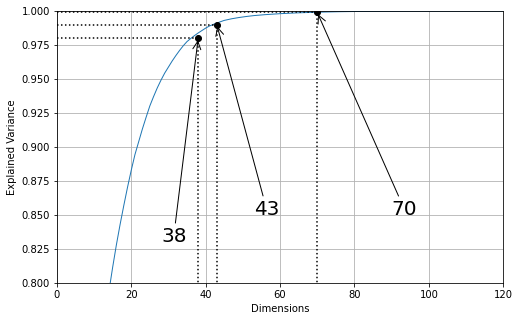

In [384]:
d = np.argmax(cumsum >= 0.999) + 1
d1 = np.argmax(cumsum >= 0.99) + 1
d2 = np.argmax(cumsum >= 0.98) + 1
plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=1)
plt.axis([0, d+50, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.999], "k:")
plt.plot([0, d], [0.999, 0.999], "k:")
plt.plot(d, 0.999, "ko")
plt.annotate(d, xy=(d, 0.999), xytext=(d+20, 0.85),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d1, d1], [0, 0.99], "k:")
plt.plot([0, d1], [0.99, 0.99], "k:")
plt.plot(d1, 0.99, "ko")
plt.annotate(d1, xy=(d1, 0.99), xytext=(d1+10, 0.85),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d2, d2], [0, 0.98], "k:")
plt.plot([0, d2], [0.98, 0.98], "k:")
plt.plot(d2, 0.98, "ko")
plt.annotate(d2, xy=(d2, 0.98), xytext=(d2-10, 0.83),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.grid(True)
plt.ylim(0.8,1)
plt.show()

In [385]:
pca = PCA(n_components=0.999)
pca.fit(x_train)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)

In [386]:
print('Dimensions x_train_pca:',x_train_pca.shape)
print('Dimensions x_test_pca:',x_test_pca.shape)

dimensions x_train_pca: (1801, 70)
dimensions x_test_pca: (596, 70)


In [407]:
pipe_dum = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy', DummyClassifier())
])
scores = cross_val_score(pipe_dum, x_train_pca, y_train, cv=5)
scores.mean()

0.333702677746999

In [389]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
scores = cross_val_score(pipe_rf, x_train_pca, y_train, cv=5)
scores.mean()

0.8678470298553401

In [390]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000))
])
scores = cross_val_score(pipe_lr, x_train_pca, y_train, cv=5)
scores.mean()

0.8711742074484456

Text(0, 0.5, 'Testing Accuracy')

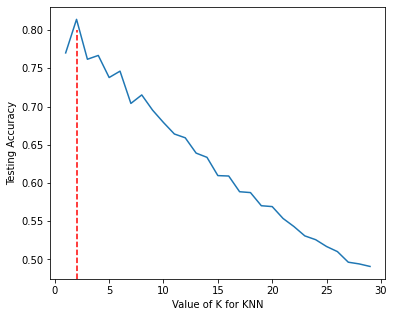

In [392]:
sc=[];k_range = list(range(1, 30))
for k in k_range:
    temppipe=Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(temppipe, x_train_pca, y_train, cv=5)
    sc.append(scores.mean())
m=sc.index(max(sc))+1
#plot graph showing percentage of accuracy by number of neighbors
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, sc)
ax.axvline(m, ls='--',ymax=max(sc)+0.1,c='r',solid_capstyle='round')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [393]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=m))
])
scores = cross_val_score(pipe_knn, x_train_pca, y_train, cv=5)
scores.mean()

0.8139827639273621

In [404]:
pipe_et = Pipeline([
    ('scaler', StandardScaler()),
    ('et', ExtraTreesClassifier())
])
scores = cross_val_score(pipe_et, x_train_pca, y_train, cv=5)
scores.mean()

0.8883948907356111

In [408]:
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',XGBClassifier(n_estimators=500,use_label_encoder=False,eval_metric='mlogloss'))
])
scores = cross_val_score(pipe_xgb, x_train_pca, y_train, cv=5)
scores.mean()

0.8839489073561095

In [409]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

In [ ]:
rf_tun = GridSearchCV(estimator = pipe_rf, param_grid = rf_grid, cv = 5, n_jobs = -1)
rf_tun.fit(x_train_pca, y_train)

rf_tun.best_params_

In [ ]:
rf_random.best_score_

In [ ]:
et_grid = {'et__n_estimators': n_estimators,
               'et__max_features': max_features,
               'et__max_depth': max_depth,
               'et__min_samples_split': min_samples_split,
               'et__min_samples_leaf': min_samples_leaf,
               'et__bootstrap': bootstrap}
et_tun = GridSearchCV(estimator = pipe_et, param_grid = et_grid, cv = 5, n_jobs = -1)
et_tun.fit(x_train_pca, y_train)

et_tun.best_params_

In [ ]:
et_tun.best_score_

In [ ]:
corr = df2.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(corr, annot=True ,linewidths=0.5, ax=ax)